In [ ]:
!pip install scikit-optimize
!pip install barplots
!pip install extra_keras_metrics
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader
!pip install keras_bed_sequence
!pip install seaborn

     |████████████████████████████████| 495 kB 7.8 MB/s 
  Created wheel for minepy: filename=minepy-1.2.5-cp37-cp37m-linux_x86_64.whl size=177549 sha256=779f34e368a80cd4f5bd9a42a9b44315f64af16f0443b2a944940193b0583b7b
  Stored in directory: /root/.cache/pip/wheels/d1/ea/d7/fabbfa6e294adcbc43dabca0e0158dafdd36051246992c7311
Successfully built minepy
     |████████████████████████████████| 101 kB 5.1 MB/s 
  Created wheel for barplots: filename=barplots-1.1.11-py3-none-any.whl size=17877 sha256=a7c596c45968c869676376a6f6c80e70bfe26cf4a45ae33b92afeddb53ee9964
  Stored in directory: /root/.cache/pip/wheels/2a/53/e4/1c71fe6cb782f2f43b23872deea5369ad81c11118361558728
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=058a34f7f07686136b4a94d8fb8a093ed82b177910a4b91eb45fb44509d3c7ab
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=comp

In [ ]:
##import silence_tensorflow.auto
from epigenomic_dataset import load_epigenomes
from epigenomic_dataset import active_promoters_vs_inactive_promoters
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from cache_decorator import Cache
from tqdm.keras import TqdmCallback
from barplots import barplots
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence
from keras_mixed_sequence import MixedSequence, VectorSequence
import matplotlib.pyplot as plt # A standard plotting library

## Data retrieval
First, we retrieve the data and impute and scale them.

In [ ]:
genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
cell_line = "H1"

X, y = active_promoters_vs_inactive_promoters(
    cell_line=cell_line,
    binarize=True,
    max_inactive_tpm_value=0.5,
    min_active_tpm_value=0.5
)

X = X.reset_index()
bed = X[X.columns[:5]]

In [ ]:
def build_sequence(
    X: pd.DataFrame,
    y: np.ndarray,
    genome: Genome,
    batch_size: int
) -> MixedSequence:
    return MixedSequence(
        x=BedSequence(
            genome,
            X,
            batch_size=batch_size,
        ),
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [ ]:
mixed_sequence = build_sequence(bed, y[cell_line].values, genome, 1024)
inputs, outputs = list(zip(*mixed_sequence))
inputs = np.vstack(inputs)
outputs = np.hstack(outputs)
inputs = inputs.reshape(-1, 256*4)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
from sklearn.decomposition import FactorAnalysis

def mfa(x:np.ndarray, n_components:int=2)->np.ndarray:
    return FactorAnalysis(n_components=n_components, random_state=42).fit_transform(x)


Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

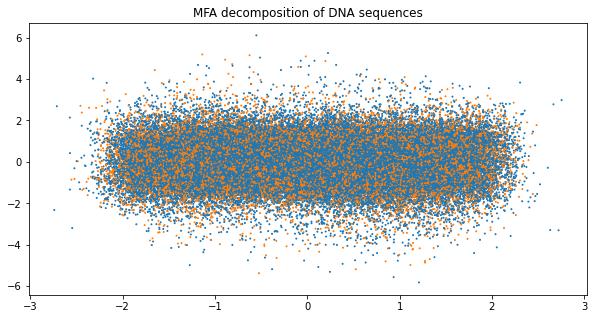

In [ ]:
from sklearn.decomposition import FactorAnalysis
colors = np.array([
    "tab:blue",
    "tab:orange",
])

train_sequence = build_sequence(bed, y.values, genome, batch_size=len(bed))
X = train_sequence.rasterize()[0].reshape(-1, 256*4).astype(int)

xseries = []
yseries = []
for example in mfa(X):
    xseries.append(example[0])
    yseries.append(example[1])

tcolors = []
for color in colors[y.values.astype(int)]:
    tcolors.append(color[0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.scatter(xseries, yseries, s=1, c=tcolors)
axes.set_title(f"MFA decomposition of DNA sequences")
plt.show()

## Bayesian Optimization for Model Selection

In [ ]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

In [ ]:
#Definition of the dimensions in which we want to find the best hyper parameter's values for the task.
dim_num_conv_units_2 = Categorical(categories=[32,64,128], name=
                                    'num_conv_units_2')
dim_num_dense_nodes_1 = Categorical(categories=[16,32,64], name=
                                    'num_dense_nodes_1')
dim_num_dense_nodes_2 = Categorical(categories=[16,32,64], name=
                                    'num_dense_nodes_2')
dim_kernel_size_2 = Categorical(categories=[5, 10], 
                               name='kernel_size_2')
dim_dropout_prob = Categorical(categories=[0.1, 0.2, 0.3, 0.4, 0.5], 
                               name='dropout_prob')
    
dimensions = [dim_num_conv_units_2,
              dim_num_dense_nodes_2,
              dim_num_dense_nodes_1,
              dim_kernel_size_2,
              dim_dropout_prob]

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv1D, Conv2D, Reshape, Flatten, MaxPool1D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.optimizers import Nadam

def create_model(    
    num_conv_units_2,           
    num_dense_nodes_2,
    num_dense_nodes_1,
    kernel_size_2,
    dropout_prob):
    
    model = Sequential()

    model.add(Input((256, 4)))
    model.add(Conv1D(64, kernel_size=5, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, kernel_size=5, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, kernel_size=5, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Conv1D(num_conv_units_2, kernel_size=int(kernel_size_2), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Flatten())
    model.add(Dense(num_dense_nodes_2, activation="relu"))
    model.add(Dropout(dropout_prob))
    model.add(Dense(num_dense_nodes_1, activation="relu"))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=Nadam(0.0002),
        metrics=['accuracy', AUC(curve='ROC', name='AUROC'),  AUC(curve='PR', name='AUPRC')]
    )

    return model

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 1
holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state = 42
)

for holdout_number, (train_indices, test_indices) in enumerate(holdouts_generator.split(bed, y)):
    X_train, X_test = bed.iloc[train_indices], bed.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

train_sequence = build_sequence(X_train, y_train.values, genome, batch_size=128)
test_sequence = build_sequence(X_test, y_test.values, genome, batch_size=128)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

n_calls = 0
@use_named_args(dimensions=dimensions)
def fitness(num_conv_units_2, num_dense_nodes_2, num_dense_nodes_1, kernel_size_2, dropout_prob):

    # Print the hyper-parameters.
    print('num_conv_units_2:', num_conv_units_2)
    print('num_dense_nodes_2:', num_dense_nodes_2)
    print('num_dense_nodes_1:', num_dense_nodes_1)
    print('kernel_size_2:', kernel_size_2)
    print('dropout_prob:', dropout_prob)
    
    # Create the neural network with these hyper-parameters.
    model = create_model(num_conv_units_2=num_conv_units_2,
                         num_dense_nodes_2=num_dense_nodes_2,
                         num_dense_nodes_1=num_dense_nodes_1,
                         kernel_size_2=kernel_size_2,
                         dropout_prob = dropout_prob)

    # Training phase
    history = model.fit(train_sequence,
                        epochs=100,
                        validation_data=test_sequence,
                        verbose=2,
                        callbacks = [EarlyStopping(monitor = "val_loss", patience = 3)])

    # I use this metric because I want to put more importance to the positive examples
    val_loss = history.history['val_loss'][-1]

    global n_calls 
    n_calls += 1
    
    # Print the result of the AUPRC metric over the validation set.
    print()
    print("n_call:"+str(n_calls)+"val_loss: {0:.2%}".format(val_loss))
    print()

    del model
    
    K.clear_session()
    
    # Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # We need to negate the result so it can be minimized.
    return val_loss

In [ ]:
%%time

default_parameters = [64, 64, 64, 10, 0.1]
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=40,
                            x0=default_parameters)

learning_rate: 0.0001
num_conv_units_2: 64
num_dense_nodes_2: 64
num_dense_nodes_1: 64
kernel_size_2: 10
Epoch 1/15
625/625 - 38s - loss: 0.6328 - accuracy: 0.6544 - AUROC: 0.6314 - AUPRC: 0.4663 - val_loss: 0.5904 - val_accuracy: 0.6899 - val_AUROC: 0.7203 - val_AUPRC: 0.5543
Epoch 2/15
625/625 - 5s - loss: 0.5670 - accuracy: 0.7003 - AUROC: 0.7397 - AUPRC: 0.5718 - val_loss: 0.5635 - val_accuracy: 0.7000 - val_AUROC: 0.7468 - val_AUPRC: 0.5821
Epoch 3/15
625/625 - 5s - loss: 0.5382 - accuracy: 0.7245 - AUROC: 0.7748 - AUPRC: 0.6253 - val_loss: 0.5598 - val_accuracy: 0.7086 - val_AUROC: 0.7510 - val_AUPRC: 0.5908
Epoch 4/15
625/625 - 5s - loss: 0.5094 - accuracy: 0.7468 - AUROC: 0.8040 - AUPRC: 0.6779 - val_loss: 0.5685 - val_accuracy: 0.7050 - val_AUROC: 0.7468 - val_AUPRC: 0.5901
Epoch 5/15
625/625 - 5s - loss: 0.4748 - accuracy: 0.7717 - AUROC: 0.8353 - AUPRC: 0.7338 - val_loss: 0.5814 - val_accuracy: 0.6944 - val_AUROC: 0.7369 - val_AUPRC: 0.5830
Epoch 6/15
625/625 - 5s - loss: 0.

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning_rate: 1e-05
num_conv_units_2: 256
num_dense_nodes_2: 16
num_dense_nodes_1: 16
kernel_size_2: 5
Epoch 1/15
625/625 - 9s - loss: 0.6660 - accuracy: 0.6329 - AUROC: 0.5239 - AUPRC: 0.3697 - val_loss: 0.6451 - val_accuracy: 0.6498 - val_AUROC: 0.5784 - val_AUPRC: 0.4237
Epoch 2/15
625/625 - 8s - loss: 0.6337 - accuracy: 0.6500 - AUROC: 0.6085 - AUPRC: 0.4451 - val_loss: 0.6157 - val_accuracy: 0.6568 - val_AUROC: 0.6614 - val_AUPRC: 0.4936
Epoch 3/15
625/625 - 8s - loss: 0.6136 - accuracy: 0.6562 - AUROC: 0.6599 - AUPRC: 0.4907 - val_loss: 0.6014 - val_accuracy: 0.6622 - val_AUROC: 0.6909 - val_AUPRC: 0.5184
Epoch 4/15
625/625 - 8s - loss: 0.5979 - accuracy: 0.6609 - AUROC: 0.6931 - AUPRC: 0.5185 - val_loss: 0.5915 - val_accuracy: 0.6642 - val_AUROC: 0.7077 - val_AUPRC: 0.5336
Epoch 5/15
625/625 - 8s - loss: 0.5845 - accuracy: 0.6764 - AUROC: 0.7154 - AUPRC: 0.5447 - val_loss: 0.5846 - val_accuracy: 0.6842 - val_AUROC: 0.7183 - val_AUPRC: 0.5404
Epoch 6/15
625/625 - 8s - loss: 0.57

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning_rate: 1e-05
num_conv_units_2: 32
num_dense_nodes_2: 16
num_dense_nodes_1: 128
kernel_size_2: 10
Epoch 1/15
625/625 - 6s - loss: 0.6706 - accuracy: 0.6155 - AUROC: 0.5069 - AUPRC: 0.3562 - val_loss: 0.6552 - val_accuracy: 0.6389 - val_AUROC: 0.5250 - val_AUPRC: 0.3672
Epoch 2/15
625/625 - 5s - loss: 0.6556 - accuracy: 0.6415 - AUROC: 0.5271 - AUPRC: 0.3723 - val_loss: 0.6474 - val_accuracy: 0.6460 - val_AUROC: 0.5471 - val_AUPRC: 0.3862
Epoch 3/15
625/625 - 5s - loss: 0.6474 - accuracy: 0.6456 - AUROC: 0.5544 - AUPRC: 0.3964 - val_loss: 0.6410 - val_accuracy: 0.6466 - val_AUROC: 0.5755 - val_AUPRC: 0.4128
Epoch 4/15
625/625 - 4s - loss: 0.6394 - accuracy: 0.6483 - AUROC: 0.5845 - AUPRC: 0.4238 - val_loss: 0.6314 - val_accuracy: 0.6499 - val_AUROC: 0.6139 - val_AUPRC: 0.4493
Epoch 5/15
625/625 - 5s - loss: 0.6285 - accuracy: 0.6523 - AUROC: 0.6227 - AUPRC: 0.4578 - val_loss: 0.6191 - val_accuracy: 0.6562 - val_AUROC: 0.6516 - val_AUPRC: 0.4819
Epoch 6/15
625/625 - 4s - loss: 0.6

In [ ]:
results = pd.DataFrame(sorted(zip(search_result.func_vals, search_result.x_iters)))
results.to_csv("best_models_promoters_0.5_cnn.csv")

In [ ]:
from ast import literal_eval
results = pd.read_csv("best_models_promoters_0.5_cnn.csv")
best_configuration = literal_eval(results["1"][0])

In [ ]:
results

,Unnamed: 0,0,1
0,0,0.556607,"[0.01, 32, 16, 64, 5]"
1,1,0.557481,"[1e-05, 256, 16, 32, 5]"
2,2,0.557630,"[0.01, 64, 128, 64, 8]"
3,3,0.560870,"[0.0001, 32, 16, 16, 10]"
4,4,0.561400,"[1e-05, 256, 16, 128, 10]"
5,5,0.561957,"[1e-05, 32, 16, 128, 10]"
6,6,0.562190,"[0.0001, 32, 16, 128, 6]"
7,7,0.564124,"[1e-05, 256, 16, 16, 5]"
8,8,0.565490,"[0.001, 32, 32, 64, 7]"
9,9,0.565578,"[0.001, 32, 16, 32, 8]"


In [ ]:
op_learning_rate = best_configuration[0]
op_num_conv_units_2 = best_configuration[1]
op_num_of_nodes_2 = best_configuration[2]
op_num_of_nodes_1 = best_configuration[3]
op_kernel_size_2 = best_configuration[4]

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv1D, Conv2D, Reshape, Flatten, MaxPool1D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from extra_keras_metrics import get_standard_binary_metrics

"""@Cache(
    cache_path=[
        "active_enhancers_performance/{function_name}/history_{_hash}.csv.xz",
        "active_enhancers_performance/{function_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "X_train", "X_test", "y_train", "y_test", "genome"
    ]
)"""
def train_cnn(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: np.ndarray,
    y_test: np.ndarray,
    genome: Genome,
    batch_size: int,
    holdout_number: int
):
    """Return performance of a FFNN.
    
    Parameters
    ----------------------
    X_train: pd.DataFrame,
        Data reserved for the input during training of the model.
    X_test: pd.DataFrame,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    genome: Genome,
        The genome object to use.
    holdout_number: int,
        Number of the holdout.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    train_sequence = build_sequence(X_train, y_train, genome, batch_size=batch_size)
    test_sequence = build_sequence(X_test, y_test, genome, batch_size=batch_size)
    
    cnn = Sequential([
        Input((256, 4)),
        Conv1D(64, kernel_size=5, activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool1D(),
        Conv1D(op_num_conv_units_2, kernel_size=int(op_kernel_size_2), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool1D(),
        Flatten(),
        Dense(op_num_of_nodes_2, activation="relu"),
        Dropout(0.1),
        Dense(op_num_of_nodes_1, activation="relu"),
        Dropout(0.1),
        Dense(1, activation="sigmoid")
    ])
    cnn.compile(
        loss="binary_crossentropy",
        optimizer=Adam(op_learning_rate),
        metrics=get_standard_binary_metrics()
    )
    
    cnn.summary()
    
    history = pd.DataFrame(cnn.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=100,
        verbose=False,
        callbacks=[
            EarlyStopping(monitor = "val_loss", patience = 2),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(cnn.metrics_names, cnn.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(cnn.metrics_names, cnn.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = "CNN"
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

### Training of the Models

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create a list to store all the computed performance
all_performance = []
number_of_splits = 10
holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state = 42
)

# Start the main loop, iterating through the holdouts
for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(holdouts_generator.split(bed, y)),
    total=number_of_splits,
    desc="Computing holdouts"
):
    X_train, X_test = bed.iloc[train_indices], bed.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    # We compute the model performance
    history, performance = train_cnn(
        X_train, X_test, y_train.values, y_test.values,
        genome,
        batch_size=128,
        holdout_number=holdout_number
    )
    # We chain the computed performance to the performance list
    all_performance.append(performance)

    
# We convert the computed performance list into a DataFrame
all_performance = pd.concat(all_performance)

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 128, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_4 (Batch (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 128, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 128, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 128, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 64, 32)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_12 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 64, 32)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_14 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 64, 32)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_16 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 64, 32)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_18 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 128, 32)           10272     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 64, 32)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
all_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,fall_out,mcc,run_type,model_name,holdout_number
0,0.638475,0.646088,0.844208,0.498678,0.762493,0.613333,0.626990,0.691258,0.538308,0.155792,0.461692,0.372452,train,CNN,0
1,0.646949,0.640537,0.843990,0.494053,0.755243,0.602854,0.623262,0.686930,0.529871,0.156010,0.470129,0.364826,test,CNN,0
0,0.566076,0.688251,0.787056,0.539478,0.730604,0.523187,0.640164,0.710778,0.634500,0.212944,0.365500,0.402912,train,CNN,1
1,0.570405,0.682935,0.779341,0.534288,0.724214,0.517369,0.633957,0.704919,0.630497,0.220659,0.369503,0.391701,test,CNN,1
0,0.559568,0.704308,0.431180,0.614571,0.757096,0.571240,0.506795,0.642036,0.852892,0.568820,0.147108,0.314571,train,CNN,2
1,0.566656,0.701557,0.428531,0.608555,0.746437,0.561690,0.502918,0.639298,0.850066,0.571469,0.149934,0.308131,test,CNN,2
0,0.568866,0.705472,0.486804,0.601334,0.753585,0.564455,0.538042,0.655616,0.824428,0.513196,0.175571,0.329274,train,CNN,3
1,0.570543,0.705411,0.489059,0.600593,0.752059,0.563133,0.539118,0.656076,0.823093,0.510941,0.176907,0.329670,test,CNN,3
0,0.551925,0.718637,0.588214,0.603301,0.758750,0.569989,0.595662,0.688902,0.789589,0.411786,0.210411,0.380041,train,CNN,4
1,0.558275,0.712820,0.579284,0.594922,0.750332,0.561193,0.586999,0.682369,0.785455,0.420716,0.214545,0.367015,test,CNN,4


In [ ]:
all_performance.to_csv("all_performances_promoters_0.5_cnn.csv")

In [ ]:
all_performance = pd.read_csv("all_performances_promoters_0.5_cnn.csv")

In [ ]:
all_performance = all_performance.filter(items=['model_name', 'run_type', 'accuracy', 'AUROC', 'AUPRC'])
all_performance.groupby(['run_type']).mean()

,accuracy,AUROC,AUPRC
run_type,,,
test,0.674300,0.667024,0.492877
train,0.677091,0.672963,0.498943


In [ ]:
barplots(
    all_performance,
    groupby=["model_name", "run_type"],
    orientation="horizontal",
    height=8
)

Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/barplots/barplot.py:294: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  figure.tight_layout()
/usr/local/lib/python3.7/dist-packages/barplots/barplot.py:294: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  figure.tight_layout()
Exception in thread Thread-18:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 470, in _handle_results
    task = get()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/figure.py", line 2